# Índice
1. [Análisis de datos](#Análisisdedatos)
 1. [Análisis de la variable dependiente](#Análisisdelavariabledependiente)
 2. [Análisis de las variables explicativas](#Análisisdelasvariablesexplicativas)
2. [Entrenamiento de modelos](#Entrenamientodemodelos)
    1. [Preparación de datos](#Preparacióndedatos)
    2. [Experimentos](#Experimentos)
    3. [Comparación de modelos](#Comparacióndemodelos)
3. [Predicción](#Predicción)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import xgboost as xgb
from bayes_opt import BayesianOptimization
from tpot import TPOTRegressor
from mlens.ensemble import SuperLearner,BlendEnsemble
from sklearn.metrics import make_scorer,precision_score,accuracy_score,recall_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,HuberRegressor,SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.model_selection import KFold,cross_val_score
from sklearn.tree import DecisionTreeRegressor

[MLENS] backend: threading


In [3]:
#Cargamos los datos de entrenamiento
train_df = pd.read_csv("data/original/Dataset_Salesforce_Predictive_Modelling_TRAIN.txt")

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


El objetivo de este reto es es desarollo de un modelo capaz de predecir el poder adquisitivo de un cliente a partir de una serie de variables disponibles para la entidad financiera. Contar con un modelo preciso que pueda llevar a cabo estars predicciones sin duda conllevaría muchas ventajas a la hora de recomendar productos al cliente que se adecuen a sus necesidades y capacidades.

<a name=Análisisdedatos></a>
# Análisis de datos

 Veamos un ejemplo de los datos con los que contamos.

In [3]:
train_df.head()

,ID_Customer,Imp_Cons_01,Imp_Cons_02,Imp_Cons_03,Imp_Cons_04,Imp_Cons_05,Imp_Cons_06,Imp_Cons_07,Imp_Cons_08,Imp_Cons_09,...,Num_Oper_17,Num_Oper_18,Num_Oper_19,Num_Oper_20,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Poder_Adquisitivo
0,TR000001,0.0,0.00,0.000000,63.067778,0.0,52.196667,0.0,0.000000,0.00,...,2,0,0,0,09991,1,70.44,3,20,19709.915000
1,TR000002,0.0,100.58,595.454545,10.899000,0.0,39.473636,0.0,62.268571,42.61,...,4,1,0,0,09991,2,71.87,3,29,37497.492167
2,TR000003,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,2,0,0,0,0X301,2,72.48,2,41,4802.970000
3,TR000004,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0,0,0,0,0X301,2,86.60,3,38,8295.770000
4,TR000005,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0,0,0,0,09991,2,92.48,4,35,24149.321667


In [4]:
train_df.columns

Index(['ID_Customer', 'Imp_Cons_01', 'Imp_Cons_02', 'Imp_Cons_03',
       'Imp_Cons_04', 'Imp_Cons_05', 'Imp_Cons_06', 'Imp_Cons_07',
       'Imp_Cons_08', 'Imp_Cons_09', 'Imp_Cons_10', 'Imp_Cons_11',
       'Imp_Cons_12', 'Imp_Cons_13', 'Imp_Cons_14', 'Imp_Cons_15',
       'Imp_Cons_16', 'Imp_Cons_17', 'Imp_Sal_01', 'Imp_Sal_02', 'Imp_Sal_03',
       'Imp_Sal_04', 'Imp_Sal_05', 'Imp_Sal_06', 'Imp_Sal_07', 'Imp_Sal_08',
       'Imp_Sal_09', 'Imp_Sal_10', 'Imp_Sal_11', 'Imp_Sal_12', 'Imp_Sal_13',
       'Imp_Sal_14', 'Imp_Sal_15', 'Imp_Sal_16', 'Imp_Sal_17', 'Imp_Sal_18',
       'Imp_Sal_19', 'Imp_Sal_20', 'Imp_Sal_21', 'Ind_Prod_01', 'Ind_Prod_02',
       'Ind_Prod_03', 'Ind_Prod_04', 'Ind_Prod_05', 'Ind_Prod_06',
       'Ind_Prod_07', 'Ind_Prod_08', 'Ind_Prod_09', 'Ind_Prod_10',
       'Ind_Prod_11', 'Ind_Prod_12', 'Ind_Prod_13', 'Ind_Prod_14',
       'Ind_Prod_15', 'Ind_Prod_16', 'Ind_Prod_17', 'Ind_Prod_18',
       'Ind_Prod_19', 'Ind_Prod_20', 'Ind_Prod_21', 'Ind_Prod_22',
       '

In [5]:
train_df.dtypes

ID_Customer           object
Imp_Cons_01          float64
Imp_Cons_02          float64
Imp_Cons_03          float64
Imp_Cons_04          float64
Imp_Cons_05          float64
Imp_Cons_06          float64
Imp_Cons_07          float64
Imp_Cons_08          float64
Imp_Cons_09          float64
Imp_Cons_10          float64
Imp_Cons_11          float64
Imp_Cons_12          float64
Imp_Cons_13          float64
Imp_Cons_14          float64
Imp_Cons_15          float64
Imp_Cons_16          float64
Imp_Cons_17          float64
Imp_Sal_01           float64
Imp_Sal_02           float64
Imp_Sal_03           float64
Imp_Sal_04           float64
Imp_Sal_05           float64
Imp_Sal_06           float64
Imp_Sal_07           float64
Imp_Sal_08           float64
Imp_Sal_09           float64
Imp_Sal_10           float64
Imp_Sal_11           float64
Imp_Sal_12           float64
                      ...   
Ind_Prod_21            int64
Ind_Prod_22            int64
Ind_Prod_23            int64
Ind_Prod_24   

In [6]:
len(train_df)

363834

Tal y como se explica en el enunciado, contamos con 88 variables que usar para predecir el poder adquisitivo y la información de cerca de 363.000 clientes con los que entrenar nuestro modelo. Esto hace que contemos con un número importante de datos que nos puede ayudar a desarrollar un modelo que tenga un rendimiento adecuado.

<a name=Análisisdelavariabledependiente> </a>
## Análisis de la variable dependiente 
Miremos con más detenimiento la variable a predecir.


In [7]:
train_df["Poder_Adquisitivo"].describe()

count    3.638340e+05
mean     1.642141e+04
std      2.436773e+04
min      3.600960e+03
25%      9.300933e+03
50%      1.292517e+04
75%      1.894854e+04
max      5.040000e+06
Name: Poder_Adquisitivo, dtype: float64

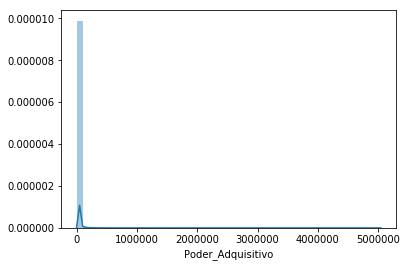

In [8]:
sns.distplot(train_df["Poder_Adquisitivo"])

In [9]:
print("Skewness: %f" % train_df["Poder_Adquisitivo"].skew())
print("Kurtosis: %f" % train_df["Poder_Adquisitivo"].kurt())

Skewness: 55.919866
Kurtosis: 7106.469270


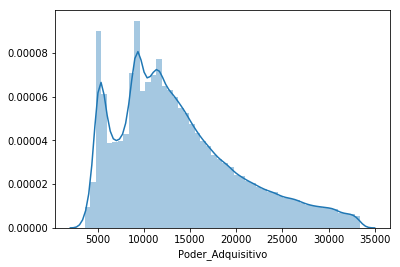

In [10]:
q1 = train_df["Poder_Adquisitivo"].quantile(0.25)
q3 = train_df["Poder_Adquisitivo"].quantile(0.75)
iqr = q3 - q1
fence_low  = q1 - 1.5 * iqr
fence_high = q3 + 1.5 * iqr

train_df_no_outliers = train_df.loc[(train_df["Poder_Adquisitivo"] > fence_low) & (train_df["Poder_Adquisitivo"] < fence_high)]
sns.distplot(train_df_no_outliers["Poder_Adquisitivo"])

In [11]:
print("Skewness: %f" % train_df_no_outliers["Poder_Adquisitivo"].skew())
print("Kurtosis: %f" % train_df_no_outliers["Poder_Adquisitivo"].kurt())

Skewness: 0.823076
Kurtosis: 0.098508


In [12]:
print("Porcentaje de datos eliminados:")
print((len(train_df.index)-len(train_df_no_outliers.index))/len(train_df.index))

Porcentaje de datos eliminados:
0.057278868934733974


Eliminando de esta manera los valores extremos, que representan alrededor del 5% de los datos totales, la distribución ahora presenta unos valores de skewness y kurtosis mucho más aceptables que permitan el entrenamiento de un modelo.

Evidentemente esta eliminación se va a realizar únicamente a la hora de entrenar, nunca a la hora de evaluar

<a name=Análisisdelasvariablesexplicativas></a>
## Análisis de las variables explicativas

De las variables explicativas, sabemos que contamos con algunas que son de tipo categórico en vez de númerico. Empezemos explorando estas variables.

In [13]:
train_df_no_outliers["Socio_Demo_01"].value_counts()

09991     97865
09992     26997
09994     20758
09993     15307
0X301     15232
09511     13078
05220      8303
06110      7633
09512      7098
06120      4987
07121      4530
04500      3986
05120      3554
08432      2732
09210      2596
9992.0     2586
06300      2501
9991.0     2443
09602      2324
04111      2221
04309      2181
09700      1914
05000      1595
03613      1565
02240      1527
02230      1491
9512.0     1481
9994.0     1407
03611      1328
05110      1326
          ...  
5993          1
3124          1
3121          1
2933.0        1
2936.0        1
8132          1
3316.0        1
3317          1
2158.0        1
3523          1
7891.0        1
3403.0        1
5892.0        1
7894.0        1
2154          1
5893          1
2156          1
2157          1
7193.0        1
2422          1
7192          1
2939.0        1
2311          1
3323          1
2323.0        1
2324.0        1
2325          1
8114          1
2415.0        1
04444         1
Name: Socio_Demo_01, Len

Podemos observar como Socio_Demo_01 que cuenta que muchos valores que solo aparecen un número muy bajo de veces. A la hora de transformar para su uso, es probable que la inclusión de los 921 valores posibles no aporte información discriminativa y solo sirva para aumentar el número de dimensiones. Una primera aproximación que mantenga un equilibrio entre complejidad y utilidad puede ser usar solo un número de estos valores, aquellos que aparezcan un mayor número de veces, y condensar el resto en una categoría "Other".

In [14]:
topk_socio_01 = train_df_no_outliers["Socio_Demo_01"].value_counts()[:10]
topk_socio_01

09991    97865
09992    26997
09994    20758
09993    15307
0X301    15232
09511    13078
05220     8303
06110     7633
09512     7098
06120     4987
Name: Socio_Demo_01, dtype: int64

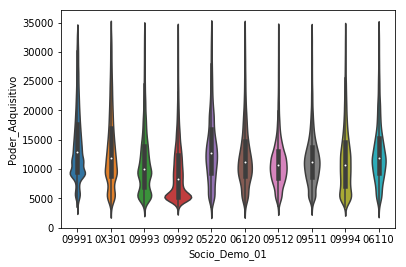

In [15]:
socio_01_keys = list(topk_socio_01.keys())
condition_array = [False] * len(train_df_no_outliers["Socio_Demo_01"])
for i in range(len(condition_array)):
    condition_array[i] = str(train_df_no_outliers["Socio_Demo_01"].iloc[i]) in socio_01_keys

sns.violinplot(x=train_df_no_outliers["Socio_Demo_01"].loc[condition_array],y=train_df_no_outliers["Poder_Adquisitivo"].loc[condition_array])

Es interesante ver como algunos valores como 09992 parecen concentrar la mayor parte de clientes en valores diferentes del resto, lo cual puede aportar información importante.

In [16]:
train_df_no_outliers["Socio_Demo_02"].value_counts()

1    206781
2    136213
Name: Socio_Demo_02, dtype: int64

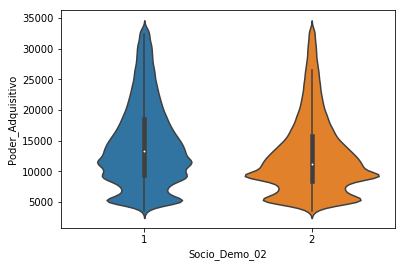

In [17]:
sns.violinplot(x=train_df_no_outliers["Socio_Demo_02"],y=train_df_no_outliers["Poder_Adquisitivo"])

Viendo la distribución de valores (61%/41%), y que las diferencias entre ambos valores no parecen muy grandes, en nuestra opinión es una opción probable que este variable represente el **sexo** del cliente.

Veamos el resto de variables socio demográficas.

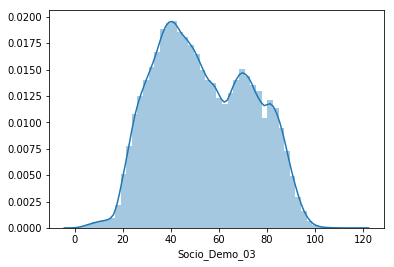

In [18]:
sns.distplot(train_df_no_outliers["Socio_Demo_03"])

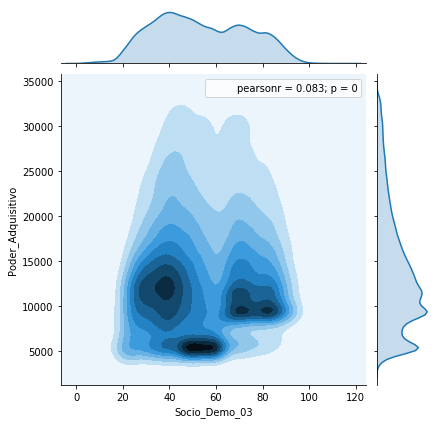

In [19]:
sns.jointplot(x=train_df_no_outliers["Socio_Demo_03"], y=train_df_no_outliers["Poder_Adquisitivo"],kind='kde')

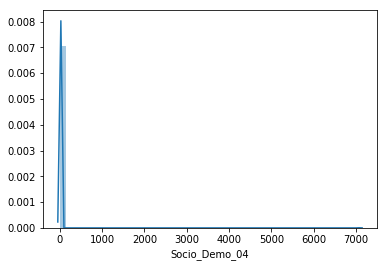

In [20]:
sns.distplot(train_df_no_outliers["Socio_Demo_04"])

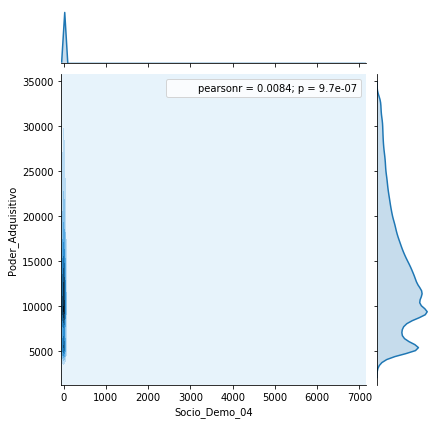

In [21]:
sns.jointplot(x=train_df_no_outliers["Socio_Demo_04"], y=train_df_no_outliers["Poder_Adquisitivo"],kind='kde')

In [22]:
train_df_no_outliers["Socio_Demo_04"].value_counts()

1       118943
2       111652
3        67361
4        33141
5         8747
6         2004
7          504
7097       280
8          149
9           56
70          42
10          21
33          20
46          20
30          14
11          11
414         10
13           8
151          6
27           2
28           2
18           1
Name: Socio_Demo_04, dtype: int64

De nuevo, observamos que una serie pequeña de valores concentra la gran mayoría de ocurrencias. Veamos si existe una relación aparente entre cada valor de esta variable y el poder adquisitivo.

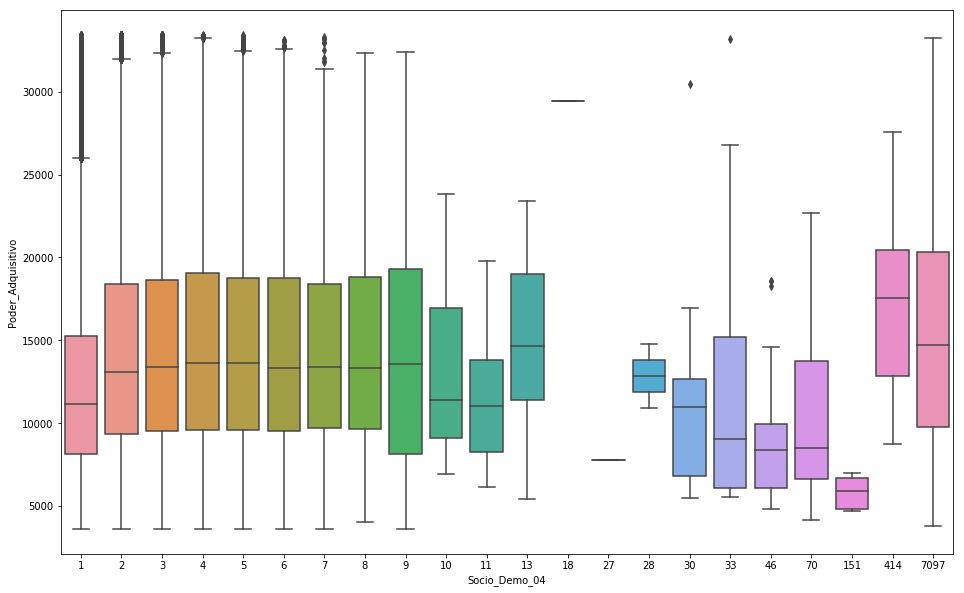

In [23]:
fig, ax = plt.subplots(figsize=(16,10))
sns.boxplot(x=train_df_no_outliers["Socio_Demo_04"], y=train_df_no_outliers["Poder_Adquisitivo"],ax=ax)

Algunos valores muestran distribuciones que son diferentes a las demás, pero aparecen un número casi insignificante de veces respecto a la totalidad de los datos, por lo que no consideremos que sea necesario complicar el modelo con esos casos.

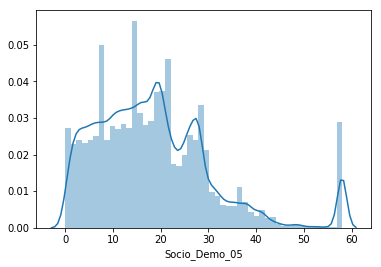

In [24]:
sns.distplot(train_df_no_outliers["Socio_Demo_05"])

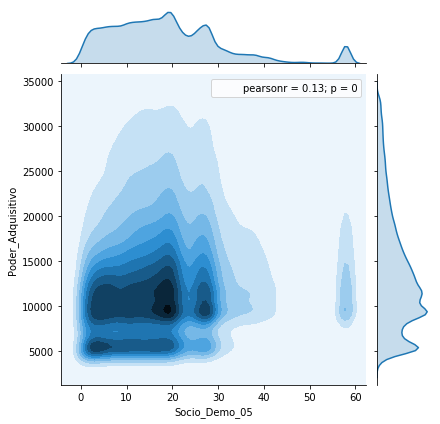

In [25]:
sns.jointplot(x=train_df_no_outliers["Socio_Demo_05"], y=train_df_no_outliers["Poder_Adquisitivo"],kind='kde')

Veamos ahora la correlación de las variables explicativas con el poder adquisitivo, medida mediante el coeficiente de Pearson.

In [26]:
train_df_no_outliers.corr(method='pearson').iloc[-1].sort_values(ascending=False,axis=0)[1:]

Imp_Sal_21       0.446199
Num_Oper_05      0.377380
Imp_Sal_19       0.364050
Ind_Prod_24      0.333431
Ind_Prod_08      0.271821
Imp_Sal_12       0.268169
Num_Oper_18      0.267717
Ind_Prod_11      0.263711
Imp_Cons_02      0.254591
Imp_Sal_08       0.254518
Imp_Cons_12      0.251392
Imp_Cons_06      0.243734
Imp_Sal_20       0.235902
Ind_Prod_05      0.229769
Imp_Cons_04      0.228519
Imp_Sal_09       0.224180
Ind_Prod_21      0.223633
Imp_Sal_04       0.221237
Imp_Cons_09      0.221097
Imp_Cons_01      0.219669
Imp_Cons_16      0.218312
Num_Oper_06      0.218307
Num_Oper_15      0.207412
Imp_Cons_03      0.203556
Ind_Prod_09      0.203247
Imp_Sal_15       0.202924
Num_Oper_02      0.196814
Imp_Sal_16       0.196771
Imp_Cons_08      0.191842
Num_Oper_08      0.190259
                   ...   
Imp_Sal_18       0.052718
Ind_Prod_04      0.051391
Ind_Prod_13      0.050400
Num_Oper_20      0.050110
Imp_Cons_14      0.049796
Num_Oper_13      0.049279
Num_Oper_09      0.042742
Num_Oper_14 

Vemos como algunas variables presentan coeficientes de correlación medios, lo que indica que serán útiles para los modelos.

<a name=Entrenamientodemodelos></a>
# Entrenamiento de modelos

<a name=Preparacióndedatos></a>
## Preparación de datos
Con todo lo visto anteriormente estamos listos para preparar los datos para la experimentación. Vamos a definir una función que realize este pre-procesado de los datos. 

La transformación básica consiste en convertir las variables categóricas a valores one-hot, y eliminar la columna ID_Customer que no es más que un identificador del cliente.


Con processing_type = 1 se puede indicar además que queremos filtrar los outliers (pero únicamente en tiempo de entrenamiento)



In [4]:
def process_df(df,processing_type,train = True):
    if processing_type == 1:
        return process_df_1(df,train)
    else:
        return process_df_1(df,False)
    
def process_df_1(df,train = True):
    df = df.drop(labels=["ID_Customer"],axis=1)
    
    if train:
        # Eliminamos los outliers solo en el caso de que estemos entrenando
        q1 = df["Poder_Adquisitivo"].quantile(0.25)
        q3 = df["Poder_Adquisitivo"].quantile(0.75)
        iqr = q3 - q1
        fence_low  = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr

        df = df.loc[(df["Poder_Adquisitivo"] > fence_low) & (df["Poder_Adquisitivo"] < fence_high)]
    
        
    
    # Convertimos las variables a one-hot

    # Socio_Demo_01
    
    topk_socio_01 = df["Socio_Demo_01"].value_counts()[:10]
    socio_01_keys = list(topk_socio_01.keys())
    
    for key in socio_01_keys:
        on = df["Socio_Demo_01"] == key
        df.insert(loc=len(df.columns), column="Socio_Demo_01_"+str(key), value=on.astype(int))
    
    # El resto lso agrupamos en 'Other'
    condition_array = [False] * len(df["Socio_Demo_01"])
    for i in range(len(condition_array)):
        condition_array[i] = str(df["Socio_Demo_01"].iloc[i]) not in socio_01_keys
    df.insert(loc=len(df.columns), column="Socio_Demo_01_Other", value=condition_array)
    df["Socio_Demo_01_Other"] = df["Socio_Demo_01_Other"].astype(int)
    
    df = df.drop(axis=1, columns=["Socio_Demo_01"])
    
    # Socio_Demo_02
    c1=df["Socio_Demo_02"] == 1
    c2=df["Socio_Demo_02"] == 2
    df.insert(loc=len(df.columns), column="Socio_Demo_02_01", value=c1.astype(int))
    df.insert(loc=len(df.columns), column="Socio_Demo_02_02", value=c2.astype(int))
    
    df = df.drop(axis=1, columns=["Socio_Demo_02"])

    
    # Convertimos todas las columnas Ind_prod a one-hot
    
    for i in range(1,25):
        column_name = "Ind_Prod_" + str(i).zfill(2)
        c0=df[column_name] == 0
        c1=df[column_name] == 1
        c2=df[column_name] == 2
        
        df.insert(loc=len(df.columns), column=column_name + "_00", value=c0.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_01", value=c1.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_02", value=c2.astype(int))
    
        df = df.drop(axis=1, columns=[column_name])
    
    
    
    return df

En primer lugar vamos a barjar los datos, y a continuación vamos a realizar una partición de los datos para realizar **validación cruzada** en 5 bloques, con el objetivo de realizar un análisis de resultados de los diferentes modelos de manera correcta y fiable.

Este método divide los datos en los conjustos de entrenamiento y test para cada partición, y los almacena en la variable splits.

In [5]:
SEED = 4
K = 5

shuffled_data = train_df.sample(frac=1,replace=False,random_state=SEED)

kf = KFold(n_splits=K)
kf.get_n_splits(shuffled_data)

def get_splits(kf,processing_type):
    splits=[]
    for train_index, test_index in kf.split(shuffled_data):
        train_data = shuffled_data.loc[train_index]
        test_data = shuffled_data.loc[test_index]

        train_data_proc = process_df(train_data,processing_type,train=True)
        test_data_proc = process_df(test_data,processing_type,train=False)


        splits.append((train_data_proc,test_data_proc))
    return splits


Dado un modelo y los splits que hemos realizado a los datos, a continuación definimos una función que, para cada partición de entrenamiento y test, entrene un modelo con los datos de entrenamiento correspondiente y calcule métricas sobre el conjunto de validación.

En lo que se refiere a métricas, en primer lugar hemos escogido la **ráiz del error cuadrático medio (RMSE)**, una de las métricas más comunes para evaluar modelos de regresión. El problema que tiene esta métrica es que penaliza de manera desmedida fallos grandes. Resulta mucho más interesante medir el funcionamiento del algoritmo con una métrica que refleje mejor su funcionamiento con la mayoría de clientes, cosa que consideramos más útil a la hora de decidirnos por un modelo u otro. Por eso medimos los resultados con respecto a la **media del error absoluto (MAE)** y a la **mediana del error (MAD).** Esta última métrica no es susceptible a outliers y nos permite conocer mejor cual es el comportamiento "medio" de cada modelo.

In [6]:
def train_and_evaluate(model,splits,skcompat=False,scaler=None):
    rmse = []
    mae = []
    mad = []
    # Para cada iteración de validación cruzada
    for s in range(len(splits)):
        train_data_proc,test_data_proc = splits[s]
        
        # Obtenemos los datos de entrenamiento
        x_train = train_data_proc.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
        y_train = train_data_proc["Poder_Adquisitivo"].as_matrix()

        # Obtenemos los datos de test
        x_test = test_data_proc.drop(labels=["Poder_Adquisitivo"], axis=1).as_matrix()
        y_test = test_data_proc["Poder_Adquisitivo"].as_matrix()
        
        # Damos la posiblidad de usar un scaler
        if scaler is not None:
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
           
        # Caso base, entrenamos un modelo y obtenemos las predicciones
        if not skcompat:
            model.fit(X=x_train,y=y_train)
            
            # For compatibility with XGBoost
            # yhat = model.predict(X=x_test)
            yhat = model.predict(x_test)
        
        # En el caso de que sea un objeto skcompat, las llamadas a los métodos son ligeramente diferentes.
        else:
            model.fit(x=x_train,y=y_train,steps=STEPS)
            yhat = model.predict(x=x_test)['scores']
        
        # Calculamos métricas 
        rmse.append(math.sqrt(mean_squared_error(y_true=y_test, y_pred=yhat)))
        mae.append(mean_absolute_error(y_true=y_test,y_pred=yhat))
        mad.append(median_absolute_error(y_true=y_test,y_pred=yhat))
        
    return (rmse,mae,mad)

Por último, nos definimos un método para guardar los resultados para su posterior visualización.

In [7]:
scores = {'modelo':[], 'rmse':[],'mae':[],'mad':[]}

def record_scores(name,rmse,mae,mad):
    scores['modelo'].append(name)
    scores['rmse'].append(rmse)
    scores['mae'].append(mae)
    scores['mad'].append(mad)

<a name=Experimentos></a>
## Experimentos

A continuación vamos a exponer una serie de resultados que hemos obtenido evaluando diferentes modelos. Cabe destacar que la cantidad de experimentos realizada es mucho mayor de la mostrada aquí, pero se ha llevado a cabo una selección de aquellos que, a nuestro juicio, son más interesantes. En caso contrario este documento hubiera sido todavía más largo de lo que ya es.

En primer lugar probaremos diferentes modelos tras aplicar el preproceso en el que eliminamos **outliers.**

In [7]:
splits = []
splits = get_splits(kf,1)

Inicialmente probamos diferentes modelos de regresión lineal.

In [32]:
model = LinearRegression()
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Linear Regresion',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 21866.239828
MAE: 5257.209822
MAD: 3039.409075


In [33]:
model = Lasso(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Lasso',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE: 21862.705461
MAE: 5255.091905
MAD: 3037.112226


In [34]:
model = Ridge(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Ridge',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 21865.927595
MAE: 5257.069194
MAD: 3039.435218


In [35]:
model = ElasticNet(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('ElasticNet',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 21810.483924
MAE: 5266.374945
MAD: 3101.583763


Todos los modelos lineales parecen obtener resultados comparables. Probamos ahora con redes neuronales.

In [36]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(25,25,25),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))



RMSE: 21802.399602
MAE: 4809.464531
MAD: 2490.107172


In [37]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(50,50,50),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))


RMSE: 21830.293209
MAE: 4797.267736
MAD: 2463.654820


In [38]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(25,25,25,25),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))


RMSE: 21817.672450
MAE: 4806.588021
MAD: 2454.712617


In [39]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(50,50,50,50),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('ANN50*4',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 21702.603384
MAE: 4728.631802
MAD: 2397.541365


In [40]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(25,25,25,25,25),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))



RMSE: 21735.605978
MAE: 4810.861191
MAD: 2486.416211


Probamos ahora diferentes modelos basados en árboles.

In [41]:
model = DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('RegressionTree',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22670.479224
MAE: 4802.948535
MAD: 2223.817397


In [42]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=5, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

RMSE: 23330.311981
MAE: 6016.309887
MAD: 3431.344350


In [43]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=7, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

RMSE: 23209.592362
MAE: 5801.514133
MAD: 3248.256406


In [44]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=17, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('RF_d17',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22885.472091
MAE: 5190.630200
MAD: 2654.554734


Podemos ver como la profundidad máxima afecta de manera importante al rendimiento.

In [45]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('RF_d23',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22861.309229
MAE: 5112.145407
MAD: 2549.585133


In [46]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('RF_d23_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22655.050330
MAE: 4621.045433
MAD: 2059.083895


El permitir que se hagan splits sobre todas las features incrementa sustancialmente el tiempo de entrenamiento, pero hace que este modelo supere al rest.

Probamos ahora con la técnica de Gradient Boosting.

In [47]:
model = GradientBoostingRegressor(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

RMSE: 22673.064999
MAE: 4826.494141
MAD: 2324.383647


In [48]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

RMSE: 22671.151048
MAE: 4826.406819
MAD: 2325.382443


In [49]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=5)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Gradient Boost_d5',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22660.424748
MAE: 4675.047281
MAD: 2163.067239


In [50]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=7)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('Gradient Boost_d7',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 22657.066140
MAE: 4597.104610
MAD: 2070.359545


De nuevo, llegados a este punto los modelos empiezan a requerar un tiempo de entrenamiento elevado a medida que se aumenta la profundidad máxima.

Una comparación importante a realizar es comprobar si nuestra idea inicial de eliminar outliers ha dado sus frutos. Probamos ahora a entrenar una serie de modelos ***sin eliminar outliers***.

In [ ]:
splits = []
splits = get_splits(kf,0)

In [52]:
model = LinearRegression()
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Linear Regression',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 20453.694566
MAE: 5780.098872
MAD: 3266.257244


In [53]:
model = MLPRegressor(max_iter=200,hidden_layer_sizes=(50,50,50,50),early_stopping=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw ANN50*4',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 20525.062038
MAE: 6248.621772
MAD: 3751.984974


In [54]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='log2',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw RF_d23',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19737.907886
MAE: 4866.009154
MAD: 2732.717625


In [55]:
model = GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5,max_depth=5)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Gradient Boost_d5',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19442.444211
MAE: 4790.685370
MAD: 2522.061022


In [56]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw RF_d23_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18624.512787
MAE: 4408.208644
MAD: 2097.194139


Sorprendentemente, si bien para el resto de modelos si que apreciamos que el filtrado de outliers supone sustanciales ganancias en términos de MAE y MAD, en el caso del Random Forest la pequeña diferencia en MAD se ve compensado por una reducción muy importante en RMSE y MAE. 

In [57]:
model = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw RF_d23_n100_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18549.374742
MAE: 4388.660762
MAD: 2089.153065


In [58]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=24, max_features='auto',min_samples_leaf=5,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw RF_d24_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18616.968611
MAE: 4404.808375
MAD: 2093.367133


In [11]:
model = GradientBoostingRegressor(random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('raw Gradient Boost_d3',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19819.147112
MAE: 4978.909701
MAD: 2805.818623


Llegados a este punto no hemos podido investigar más configuraciones debido a falta de tiempo y que las diferentes prubas de cambios de hiperparámetros, si bien aportan una pequeña mejora de los resultados, también han traido un aumento muy sustancial del tiempo de cómputo.

<a name=Comparacióndemodelos></a>
## Comparación de modelos

In [59]:
scores_df = pd.DataFrame(data=scores)

scores_df = scores_df.set_index('modelo')

display(scores_df)

,mad,mae,rmse
modelo,,,
Linear Regresion,3039.409075,5257.209822,21866.239828
Lasso,3037.112226,5255.091905,21862.705461
Ridge,3039.435218,5257.069194,21865.927595
ElasticNet,3101.583763,5266.374945,21810.483924
ANN50*4,2397.541365,4728.631802,21702.603384
RegressionTree,2223.817397,4802.948535,22670.479224
RF_d17,2654.554734,5190.630200,22885.472091
RF_d23,2549.585133,5112.145407,22861.309229
RF_d23_FULL,2059.083895,4621.045433,22655.050330


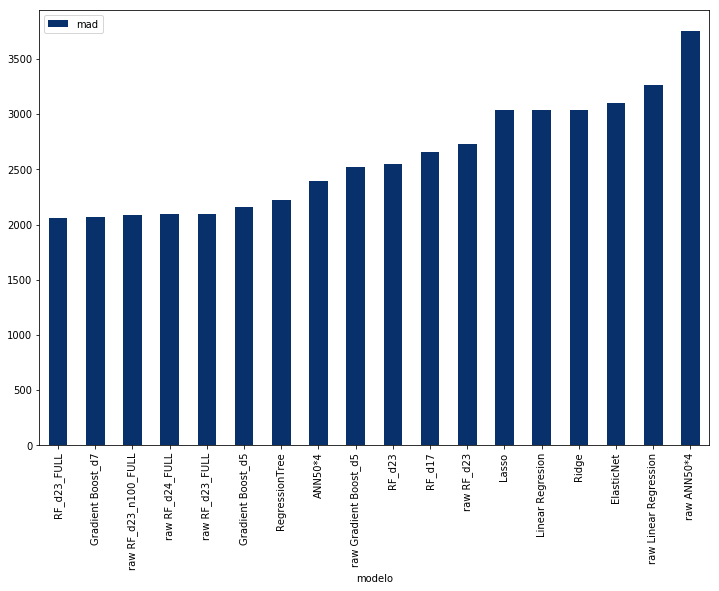

In [60]:
scores_df = scores_df.sort_values(by="mad")
scores_df.plot(kind='bar',y='mad',colormap='Blues_r',figsize=(12, 8))

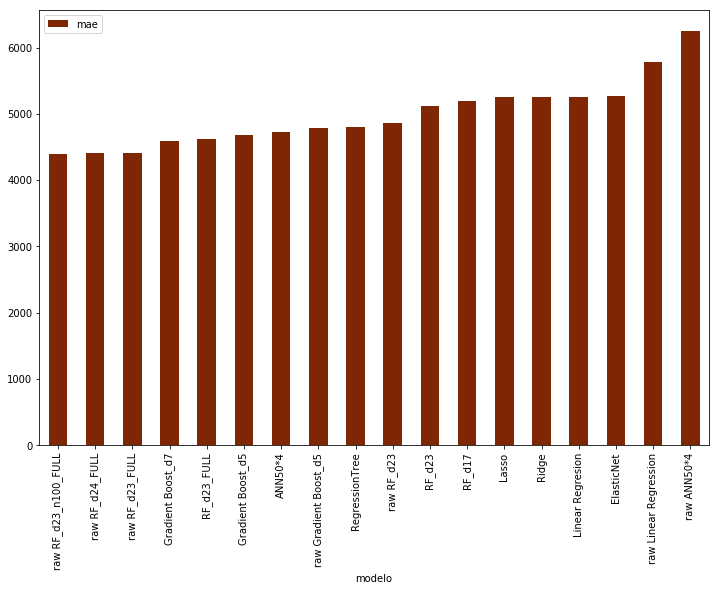

In [61]:
scores_df = scores_df.sort_values(by="mae")
scores_df.plot(kind='bar',y='mae',colormap='Oranges_r',figsize=(12, 8))

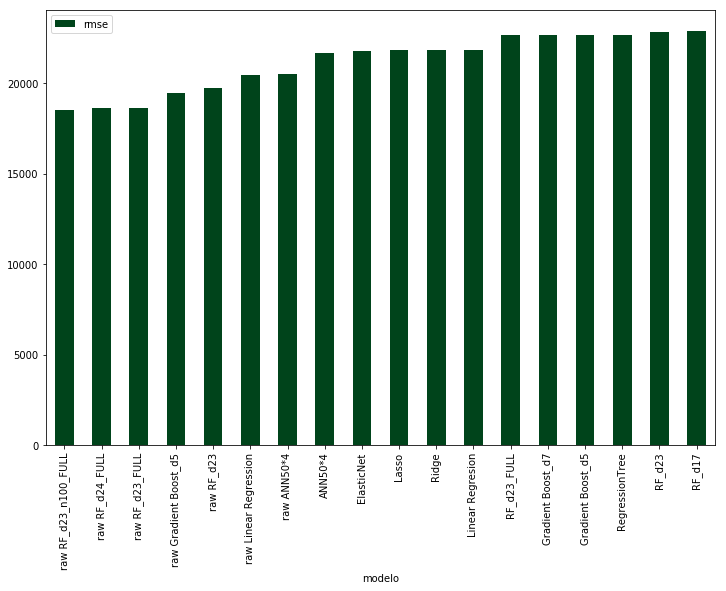

In [62]:
scores_df = scores_df.sort_values(by="rmse")
scores_df.plot(kind='bar',y='rmse',colormap='Greens_r',figsize=(12, 8))

Teniendo en cuenta todo esto, finalmente nos hemos decidido por el modelo **raw RF_d23_n100_FULL**. Inicialmente, y con la mayoría de modelos, nuestra idea inicial de eliminar outliers había obtenido mejoras muy grandes en MAE y MAD que, a nuestro juicio, compensaban de sobra pequeñas pérdidas en RMSE ya que mejoraban el conjunto de las predicciones. Sin embargo, los modelos de Random Forest profundos han demostrado que son capaces de reducir de enorme manera los grandes errores cometidos en algunos clientes puntuales, a cambio de una pequeña pérdida de MAD. Si bien el rendimiento se reducirá muy ligeramente en general (en realidad se reduce de manera ínfima, si nos fijamos en el MAD, significa que el error mediano empeora sólo en 30€), esto nos va a permitir cometer fallos mucho más pequeños en clientes atípicos, ya que reducimos en más de 4000€ el RMSE, por lo que finalmente hemos optado por este modelo. 

<a name=Predicción></a>
# Predicción

In [63]:
splits = []

model = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,random_state=SEED)

# Entrenamos con todos los datos
f_train_df = process_df(train_df,0,train = True)

x_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()



model.fit(X=x_train,y=y_train)


test_df = pd.read_csv("data/original/Dataset_Salesforce_Predictive_Modelling_TEST.txt")
ids = test_df["ID_Customer"].copy()
test_df =  process_df(test_df,0,train = False)

x_test = test_df.as_matrix()

# Estiamamos el poder adquisitivo
y = model.predict(X=x_test)




/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Solo nos falta escribir estos resultados en disco.

In [64]:
out = pd.DataFrame(np.stack((ids, y), axis=1, out=None), columns=['ID_Customer', 'PA_Est']).set_index('ID_Customer')
out.to_csv('Test_Mission.txt')

# Experimentos fase 2

In [25]:
splits = []
splits = get_splits(kf,2)

In [27]:
model = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=23, max_features='auto',min_samples_leaf=5,n_jobs=4,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('process_2_raw RF_d23_FULL',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18624.512787
MAE: 4408.208644
MAD: 2097.194139


In [28]:
splits = []
splits = get_splits(kf,0)

In [ ]:
%%time
model = MLPRegressor(activation='logistic',max_iter=200,hidden_layer_sizes=(25,25,25),verbose=True,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('sigmoid_NN_25*3',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [13]:
%%time
params =  {'max_depth': 7, 'eta': 0.1, 'silent': 1, 'objective': 'reg:linear', 'eval_metric':'rmse','nthread':3, 'seed':SEED}
model = XGBoostModel(params,100)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d7_eta0.1_n100',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19578.289591
MAE: 4740.829391
MAD: 2533.919437
CPU times: user 4min 56s, sys: 1.26 s, total: 4min 57s
Wall time: 1min 43s


In [14]:
%%time
params =  {'max_depth': 9, 'eta': 0.1, 'silent': 1, 'objective': 'reg:linear', 'eval_metric':'rmse','nthread':3,'seed':SEED}
model = XGBoostModel(params,100)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d9_eta0.1_n100',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19439.278279
MAE: 4584.188271
MAD: 2351.787121
CPU times: user 6min 31s, sys: 1.27 s, total: 6min 32s
Wall time: 2min 14s


In [16]:
%%time
params =  {'max_depth': 13, 'eta': 0.1, 'silent': 1, 'objective': 'reg:linear', 'eval_metric':'rmse','nthread':3,'seed':SEED}
model = XGBoostModel(params,100)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d13_eta0.1_n100',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19804.278757
MAE: 4531.007204
MAD: 2221.789747
CPU times: user 8min 3s, sys: 1.37 s, total: 8min 4s
Wall time: 2min 45s


In [11]:
%%time
params =  {'max_depth': 13, 'eta': 0.1, 'silent': 1, 'objective': 'reg:linear', 'subsample':0.8,'eval_metric':'rmse','nthread':4,'seed':SEED}
model = XGBoostModel(params,100)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d13_eta0.1_n100_sbspl',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18678.497090
MAE: 4462.721005
MAD: 2197.574291
CPU times: user 9min 11s, sys: 2.41 s, total: 9min 14s
Wall time: 2min 37s


# Bayesian optimization

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

xgtrain = xgb.DMatrix(X_train, label=y_train)


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)


    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(5)])

    return -cv_result['test-mae-mean'].values[-1]





random_state = SEED
num_iter = 50
init_points = 25
params = {
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'mae',
    'verbose_eval': True,
    'seed': random_state
}

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 20),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 15),
                                            'alpha': (0, 15),
                                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter)

print(xgbBO.res['max'])

Initialization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[62]	train-mae:4130.05+51.3704	test-mae:4788.21+70.5085

    1 | 02m24s | -4788.20850 |   10.0781 |             0.1978 |    9.9427 |     17.0602 |            17.9064 |      0.5962 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[33]	train-mae:3901.73+46.1966	test-mae:4610.13+97.5695

    2 | 02m08s | -4610.12549 |    7.3736 |             0.3830 |    4.6324 |     16.6396 |             5.8891 |      0.5404 | 
Multiple eval metrics have been passed

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[30]	train-mae:4602.93+40.4748	test-mae:4723.73+68.7949

   24 | 00m59s | -4723.72891 |   12.5231 |             0.5207 |   10.0397 |      7.2705 |            16.3497 |      0.8668 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
   25 | 01m55s | -5107.27363 |    9.6857 |             0.1004 |   11.9916 |     17.2813 |            12.9741 |      0.6756 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
   26 | 02m57s | -4834.96143 |    0.0000 |             1.00

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 3, 'warnflag': 2, 'funcalls': 46, 'grad': array([22.77175445]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[31]	train-mae:3201.72+73.6674	test-mae:4354.08+65.7728

   47 | 04m48s | -4354.08496 |   15.0000 |             1.0000 |    9.4112 |     20.0000 |            13.7491 |      1.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 5, 'warnflag': 2, 'funcalls': 50, 'grad': array([18.41588533]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[31]	train-mae:3161.27+58.8051	test-mae:4394.74+76.7109

   48 | 05m41s | -4394.74209 |    0.0000 |             1.0000 |    0.0000 |     20.0000 |             1.0000 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	train-mae:3823.36+55.311	test-mae:4369.29+65.8738

   49 | 05m05s | -4369.28936 |    0.0000 |             1.0000 |    8.1443 |     20.0000 |            20.0000 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[30]	train-mae:3382.72+82.3242	test-mae:4361.09+69.5503

   50 | 04m10s | -4361.08877 |   11.4383 |             1.0000 |    8.6648 |     

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 3, 'warnflag': 2, 'funcalls': 52, 'grad': array([-89.8902353]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[30]	train-mae:3287.24+100.503	test-mae:4378.38+71.5045

   61 | 03m52s | -4378.38154 |    0.0000 |             1.0000 |   15.0000 |     17.1149 |             6.7557 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	train-mae:3354.51+85.0292	test-mae:4373.52+68.4778

   62 | 04m02s | -4373.51855 |    7.3473 |             1.0000 |   11.3598 |     18.6406 |            10.1217 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
   63 | 01m38s | -5015.07041 |    0.0000 |             0.1000 |    0.0000 |     15.2808 |             5.2450 |      1.0000 | 
Multiple eval metrics have been pass

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'warnflag': 2, 'funcalls': 54, 'grad': array([-34.81049328]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[32]	train-mae:3050.75+105.031	test-mae:4363.05+85.3824

   67 | 04m11s | -4363.05293 |    0.0000 |             1.0000 |   15.0000 |     17.8881 |             3.5899 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	train-mae:3499.91+68.8239	test-mae:4417.2+64.4809

   68 | 05m11s | -4417.19756 |    0.0000 |             1.0000 |    6.5868 |     20.0000 |             6.6539 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[30]	train-mae:3135.86+78.0751	test-mae:4363.43+64.704

   69 | 04m43s | -4363.43213 |    6.2545 |             1.0000 |   15.0000 |     2

In [ ]:
f_train_df = process_df(shuffled_data,1,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

xgtrain = xgb.DMatrix(X_train, label=y_train)


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)


    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(5)])

    return -cv_result['test-mae-mean'].values[-1]





random_state = SEED
num_iter = 50
init_points = 25
params = {
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'mae',
    'verbose_eval': True,
    'seed': random_state
}

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 20),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 15),
                                            'alpha': (0, 15),
                                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter)

print(xgbBO.res['max'])

Initialization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
    1 | 07m01s | -2698.59751 |   14.3607 |             0.5458 |    7.3322 |     17.7553 |            17.6578 |      0.5304 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
    2 | 02m38s | -2736.03525 |    8.3728 |             0.5093 |    8.1203 |      7.1922 |             2.1948 |      0.6547 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
    3 | 04m30s | -2674.41733 |   11.4756 |             0.5055 | 

   28 | 02m48s | -2787.15928 |    0.0000 |             1.0000 |   15.0000 |      5.0000 |             1.0000 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
   29 | 02m47s | -2785.70298 |    0.0000 |             1.0000 |   15.0000 |      5.0000 |            20.0000 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
   30 | 12m36s | -2655.35845 |   15.0000 |             1.0000 |    0.0000 |     20.0000 |            20.0000 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[82]	train-mae:1862.17+6.40526	test-mae:2675.09+9.95526

   31 | 11m59s | -2675.09385 |    0.0000 |             1.0000 |   15.0000 |     20.0000 |            20.0000 |      0.5

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 3, 'warnflag': 2, 'funcalls': 49, 'grad': array([-2.83061967]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
   35 | 07m46s | -2668.32959 |   15.0000 |             1.0000 |    0.0000 |     11.2433 |            16.5759 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[56]	train-mae:1700.24+8.25707	test-mae:2695.32+9.4902

   36 | 08m53s | -2695.31699 |    0.0000 |             1.0000 |    8.6014 |     20.0000 |            11.0022 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[80]	train-mae:1026.42+11.3843	test-mae:2748.05+7.0834

   37 | 13m32s | -2748.04595 |   15.0000 |             1.0000 |   15.0000 |     20.0000 |             1.0000 |      0.5000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'warnflag': 2, 'funcalls': 49, 'grad': array([-3.37303771]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
   38 | 02m51s | -2787.15928 |    0.0000 |             1.0000 |    0.0000 |      5.0000 |             1.0000 |      1.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'nit': 4, 'warnflag': 2, 'funcalls': 54, 'grad': array([-4.65460886]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
   39 | 08m43s | -2672.04448 |    5.6087 |             1.0000 |    6.5406 |     12.8245 |             5.5884 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[91]	train-mae:1121.21+8.2171	test-mae:2666.36+9.48642

   40 | 12m31s | -2666.36050 |    3.4790 |             1.0000 |   15.0000 |     20.0000 |            14.6203 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 5 rounds.
   41 | 09m59s | -2667.49980 |    8.1387 |             1.0000 |    0.0000 |     14.1760 |            14.9432 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't im

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

def model_evaluate(n_estimators,
                 max_depth,
                max_features,
                 min_samples_leaf,
                  ):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    max_features = max(min(max_features, 1), 0.1)

    model = RandomForestRegressor(n_estimators=n_estimators,
                 max_depth=max_depth,
                max_features=max_features,
                 min_samples_leaf=min_samples_leaf,
                                 n_jobs=4,random_state=SEED)

    cv_result = cross_val_score(model,X_train,y_train,cv=kf,scoring="neg_mean_absolute_error")

    return np.mean(cv_result)


num_iter = 50
init_points = 15


modelBO = BayesianOptimization(model_evaluate, {'n_estimators': (30, 100),
                                            'max_depth': (15, 25),
                                            'min_samples_leaf': (1, 200),
                                                'max_features' :(0.1,1),
                                            })

modelBO.maximize(init_points=init_points, n_iter=num_iter)

print(modelBO.res['max'])

Initialization
--------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   min_samples_leaf |   n_estimators | 
    1 | 11m14s | -4540.52871 |     17.0218 |         0.9320 |           103.5466 |        54.4305 | 
    2 | 07m41s | -4503.09581 |     23.4898 |         0.5071 |            83.1047 |        69.7376 | 
    3 | 04m07s | -4580.16193 |     22.8209 |         0.2464 |           103.2144 |        78.8343 | 
    4 | 03m39s | -4528.24184 |     22.3052 |         0.4413 |            90.0890 |        39.1441 | 
    5 | 10m42s | -4552.34505 |     19.9747 |         0.9336 |           119.2446 |        60.3089 | 
    6 | 05m07s | -4599.02453 |     21.2158 |         0.5243 |           172.4681 |        51.8122 | 
    7 | 02m20s | -4623.57257 |     17.2960 |         0.1798 |            78.1636 |        57.5126 | 
    8 | 05m31s | -4577.53616 |     18.0877 |         0.5204 |           142.515

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.07055435]), 'warnflag': 2, 'funcalls': 50, 'nit': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


Bayesian Optimization
--------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   min_samples_leaf |   n_estimators | 
   16 | 26m30s | -4413.12744 |     25.0000 |         1.0000 |             1.0000 |       100.0000 | 
   17 | 19m25s | -4451.26574 |     15.0000 |         1.0000 |            31.1330 |       100.0000 | 
   18 | 17m12s | -4640.22519 |     15.0000 |         1.0000 |           200.0000 |       100.0000 | 
   19 | 05m31s | -4633.62321 |     25.0000 |         1.0000 |           200.0000 |        30.0000 | 
   20 | 02m23s | -4605.37147 |     25.0000 |         0.1000 |            22.6283 |        86.5670 | 
   21 | 20m48s | -4554.21702 |     15.0000 |         1.0000 |             1.0000 |       100.0000 | 
   22 | 08m22s | -4475.91075 |     25.0000 |         1.0000 |             1.0000 |        30.0000 | 
   23 | 17m06s | -4448.54053 |     15.0000 |         1.0000 |           

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-35.99402618]), 'warnflag': 2, 'funcalls': 49, 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   38 | 18m36s | -4545.29629 |     25.0000 |         1.0000 |           112.2086 |       100.0000 | 
   39 | 13m13s | -4560.85757 |     15.0000 |         1.0000 |             1.0000 |        63.9616 | 
   40 | 00m48s | -4862.79507 |     15.0000 |         0.1000 |           115.8828 |        30.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([15.71963441]), 'warnflag': 2, 'funcalls': 55, 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   41 | 01m31s | -4896.38496 |     15.0000 |         0.1000 |           200.0000 |        66.6198 | 
   42 | 20m19s | -4421.97114 |     25.0000 |         1.0000 |            46.8251 |       100.0000 | 
   43 | 00m48s | -4841.19216 |     15.0000 |         0.1000 |            90.1040 |        30.0000 | 
   44 | 07m31s | -4537.07890 |     25.0000 |         1.0000 |           101.5087 |        39.6810 | 
   45 | 01m52s | -4773.12275 |     15.0000 |         0.1000 |             1.0000 |        73.6999 | 
   46 | 02m02s | -4569.00121 |     25.0000 |         0.1000 |             1.0000 |        61.5207 | 
   47 | 17m35s | -4420.05119 |     16.6826 |         1.0000 |            18.5095 |        87.0044 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-58.59802675]), 'warnflag': 2, 'funcalls': 54, 'nit': 5, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


   48 | 00m47s | -4903.09589 |     15.0000 |         0.1000 |           176.9519 |        30.0000 | 
   49 | 21m01s | -4381.25574 |     25.0000 |         1.0000 |            31.3392 |       100.0000 | 
   50 | 02m19s | -4853.64287 |     25.0000 |         0.1000 |           200.0000 |       100.0000 | 
   51 | 12m15s | -4594.31543 |     15.0000 |         1.0000 |           134.2039 |        68.8224 | 
   52 | 18m11s | -4382.53311 |     18.1039 |         1.0000 |            15.5307 |        85.4920 | 
   53 | 21m09s | -4381.25574 |     25.0000 |         1.0000 |            31.1587 |       100.0000 | 
   54 | 20m58s | -4381.41963 |     25.0000 |         1.0000 |            31.2362 |       100.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-104.96731758]), 'warnflag': 2, 'funcalls': 99, 'nit': 10, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3214.91754675]), 'warnflag': 2, 'funcalls': 85, 'nit': 5, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3019598.07799578]), 'warnf

   55 | 06m19s | -4481.37980 |     25.0000 |         1.0000 |            63.7970 |        30.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-162.25976562]), 'warnflag': 2, 'funcalls': 87, 'nit': 8, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-13450949.75390625]), 'warnflag': 2, 'funcalls': 48, 'nit': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-167.64257812]), 'warnfl

   56 | 20m14s | -4410.87160 |     25.0000 |         1.0000 |            41.4808 |       100.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-125.14624023]), 'warnflag': 2, 'funcalls': 58, 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7104.13757324]), 'warnflag': 2, 'funcalls': 85, 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-63.06018066]), 'warnflag': 2

   57 | 19m50s | -4467.61924 |     25.0000 |         1.0000 |            62.0486 |       100.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-71.05078125]), 'warnflag': 2, 'funcalls': 76, 'nit': 5, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1280.29882812]), 'warnflag': 2, 'funcalls': 76, 'nit': 7, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-75008.71875]), 'warnflag': 2

   58 | 12m34s | -4441.85456 |     25.0000 |         1.0000 |            53.3486 |        61.0618 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-15016592.21717875]), 'warnflag': 2, 'funcalls': 30, 'nit': 1, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3128.04262193]), 'warnflag': 2, 'funcalls': 57, 'nit': 3, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.56999081]), 'warnflag

   59 | 06m49s | -4384.87485 |     25.0000 |         1.0000 |            26.1014 |        30.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-11843997.3203125]), 'warnflag': 2, 'funcalls': 43, 'nit': 3, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-367.19726562]), 'warnflag': 2, 'funcalls': 75, 'nit': 7, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6427.203125]), 'warnflag'

   60 | 03m39s | -4523.67206 |     24.3765 |         0.1394 |            24.8970 |        99.8920 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-103789.9005127]), 'warnflag': 2, 'funcalls': 49, 'nit': 3, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9103624.19458008]), 'warnflag': 2, 'funcalls': 35, 'nit': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-293.99523926]), 'warnf

   61 | 12m12s | -4600.48569 |     25.0000 |         1.0000 |           160.2383 |        67.0591 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-82388.17578125]), 'warnflag': 2, 'funcalls': 55, 'nit': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([12.3046875]), 'warnflag': 2, 'funcalls': 54, 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1183.34765625]), 'warnflag': 

   62 | 19m09s | -4515.69147 |     25.0000 |         1.0000 |            89.5018 |       100.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-19719.24030368]), 'warnflag': 2, 'funcalls': 54, 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1459.65958224]), 'warnflag': 2, 'funcalls': 71, 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1811.25525859]), 'warnflag

   63 | 14m03s | -4492.46127 |     15.0000 |         1.0000 |            55.5765 |        73.7182 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-16025.66015625]), 'warnflag': 2, 'funcalls': 52, 'nit': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-97.703125]), 'warnflag': 2, 'funcalls': 50, 'nit': 6, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-232.74609375]), 'warnflag': 2

   64 | 21m17s | -4393.63405 |     25.0000 |         1.0000 |            35.7299 |       100.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1225.39233398]), 'warnflag': 2, 'funcalls': 51, 'nit': 3, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-71.46948242]), 'warnflag': 2, 'funcalls': 73, 'nit': 6, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-119.87402344]), 'warnflag': 

   65 | 18m39s | -4623.48373 |     15.0000 |         1.0000 |           174.5441 |       100.0000 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-480.83203125]), 'warnflag': 2, 'funcalls': 57, 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-191.8046875]), 'warnflag': 2, 'funcalls': 69, 'nit': 6, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6915.34375]), 'warnflag': 2, '

{'max_params': {'max_features': 1.0, 'max_depth': 25.0, 'min_samples_leaf': 31.339168438211956, 'n_estimators': 100.0}, 'max_val': -4381.255735854744}


In [10]:
%%time 
model = RandomForestRegressor(n_estimators=100,
                 max_depth=25,
                max_features=1.0,
                 min_samples_leaf=31,
                                 n_jobs=4,random_state=SEED)

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('bla',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18958.802741
MAE: 4409.980381
MAD: 2103.408127
CPU times: user 1h 20min 7s, sys: 7.76 s, total: 1h 20min 15s
Wall time: 22min 25s


In [ ]:
49 | 21m01s | -4381.25574 |     25.0000 |         1.0000 |            31.3392 |       100.0000

In [ ]:
f_train_df = process_df(shuffled_data,0,train = True)

X_train = f_train_df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = f_train_df["Poder_Adquisitivo"].as_matrix()

def model_evaluate(n_estimators,
                 max_depth,
                max_features,
                 min_samples_leaf,
                  ):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    max_features = max(min(max_features, 1), 0.1)

    model = RandomForestRegressor(n_estimators=n_estimators,
                 max_depth=max_depth,
                max_features=max_features,
                 min_samples_leaf=min_samples_leaf,
                                 n_jobs=4,random_state=SEED)

    cv_result = cross_val_score(model,X_train,y_train,cv=kf,scoring="neg_median_absolute_error")

    return np.mean(cv_result)


num_iter = 50
init_points = 10


modelBO_2 = BayesianOptimization(model_evaluate, {'n_estimators': (30, 100),
                                            'max_depth': (17, 27),
                                            'min_samples_leaf': (5, 200),
                                                'max_features' :(0.5,1),
                                            })

modelBO_2.maximize(init_points=init_points, n_iter=num_iter)

print(modelBO_2.res['max'])

Initialization
--------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   min_samples_leaf |   n_estimators | 
    1 | 07m52s | -2168.04828 |     18.5297 |         0.5234 |            82.4791 |        62.5091 | 
    2 | 09m30s | -2197.43612 |     19.8388 |         0.5903 |           144.9095 |        73.5402 | 
    3 | 06m20s | -2065.98203 |     26.1318 |         0.8311 |            22.6423 |        31.2765 | 
    4 | 12m17s | -2155.39113 |     25.9128 |         0.7063 |           106.3561 |        88.9783 | 
    5 | 04m48s | -2161.64365 |     22.9905 |         0.7064 |           107.5878 |        33.0676 | 
    6 | 15m34s | -2059.42279 |     26.2037 |         0.7990 |            24.6675 |        86.9009 | 
    7 | 03m57s | -2102.27661 |     21.4343 |         0.5095 |            25.8859 |        33.3919 | 
    8 | 09m08s | -2188.91449 |     19.1931 |         0.7059 |           147.543

/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2, 'grad': array([-1.95004798])}
  " state: %s" % convergence_dict)


   14 | 20m48s | -2080.09373 |     27.0000 |         1.0000 |            42.0589 |       100.0000 | 
   15 | 17m32s | -2208.06224 |     17.0000 |         1.0000 |           200.0000 |       100.0000 | 
   16 | 25m00s | -2034.34135 |     27.0000 |         1.0000 |             5.0000 |       100.0000 | 
   17 | 08m18s | -2159.08020 |     18.7570 |         0.7100 |           100.1012 |        60.9053 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 7, 'warnflag': 2, 'grad': array([-122.67559534])}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 2, 'warnflag': 2, 'grad': array([-29443.27204963])}
  " state: %s" % convergence_dict)


   18 | 05m35s | -2129.09630 |     19.3064 |         0.7107 |            63.1006 |        39.8425 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 109, 'nit': 5, 'warnflag': 2, 'grad': array([-352.90437809])}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 8, 'warnflag': 2, 'grad': array([0.01862529])}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'fu

   19 | 10m37s | -2054.92068 |     24.5705 |         0.6669 |             6.5524 |        64.3135 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 5, 'warnflag': 2, 'grad': array([-53.51443224])}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 3, 'warnflag': 2, 'grad': array([-883.62634687])}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'f

   20 | 05m42s | -2147.86735 |     17.8081 |         0.8182 |            78.4415 |        35.6403 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2, 'grad': array([-4234.60860348])}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 8, 'warnflag': 2, 'grad': array([0.02546104])}
  " state: %s" % convergence_dict)


   21 | 04m22s | -2145.46767 |     20.1712 |         0.5506 |            63.1687 |        34.9330 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 5, 'warnflag': 2, 'grad': array([-302.00755119])}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2, 'grad': array([-3438.22931707])}
  " state: %s" % convergence_dict)


   22 | 06m19s | -2105.34391 |     21.0832 |         0.6531 |            45.7324 |        41.4895 | 


/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2, 'grad': array([-27555.84500343])}
  " state: %s" % convergence_dict)
/home/jairsan/Documents/dev/AlwaysLearningDeeper/Salesforce-Predictive-Modelling/venv/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 113, 'nit': 8, 'warnflag': 2, 'grad': array([-1334.26857213])}
  " state: %s" % convergence_dict)


In [9]:
%%time 
model = RandomForestRegressor(n_estimators=100,
                 max_depth=27,
                max_features=1.0,
                 min_samples_leaf=5,
                                 n_jobs=4,random_state=SEED)

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('bla',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18550.904712
MAE: 4379.727630
MAD: 2076.957982
CPU times: user 1h 38min 13s, sys: 8.36 s, total: 1h 38min 22s
Wall time: 27min 15s


In [8]:
splits = []
splits = get_splits(kf,0)

In [10]:
%%time
model = xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED )

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('bla',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19757.804962
MAE: 4396.969544
MAD: 2097.510848
CPU times: user 11min 34s, sys: 2.86 s, total: 11min 36s
Wall time: 3min 19s


In [9]:
%%time
model = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=20.0,random_state=SEED )

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('bla',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19118.545240
MAE: 4397.943756
MAD: 2068.395546
CPU times: user 15min 17s, sys: 2.26 s, total: 15min 19s
Wall time: 4min 13s


In [10]:
splits = []

In [41]:
"""
%%time
params =  {'max_depth': 9, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric':'rmse','seed':SEED}
model = XGBoostModel(params,500)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))
record_scores('raw_XGB_d9_eta0.01_n500',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))
"""

RMSE: 19743.195506
MAE: 4716.346445
MAD: 2434.435083
CPU times: user 44min 4s, sys: 736 ms, total: 44min 5s
Wall time: 44min 9s


## Stacking ml-ens

In [12]:
X_train = process_df(stk_train_df,0).drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_train = process_df(stk_train_df,0)["Poder_Adquisitivo"].as_matrix()

X_test = process_df(stk_test_df,0).drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
y_ts = process_df(stk_test_df,0)["Poder_Adquisitivo"].as_matrix()


In [20]:

ensemble = BlendEnsemble(verbose=2)

ensemble.add([LinearRegression(),
          DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED),
          GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5),
          RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=1,
                                       min_samples_leaf=5,random_state=SEED)])

ensemble.add_meta(GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5))

ensemble.fit(X_train, y_train)
y_hat = ensemble.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_true=y_ts, y_pred=y_hat))
mae = mean_absolute_error(y_true=y_ts,y_pred=y_hat)
mad = median_absolute_error(y_true=y_ts,y_pred=y_hat)
    
print("RMSE: %f" % rmse)
print("MAE: %f" % mae)
print("MAD: %f" % mad)

"""
RMSE: 18314.671966
MAE: 4393.416766
MAD: 2169.596094

"""


Fitting 2 layers
Processing layer-1             done | 00:09:35
Processing layer-2             done | 00:00:07
Fit complete                        | 00:09:43

Predicting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01


In [22]:
ensemble = BlendEnsemble(test_size=0.2,verbose=2)

ensemble.add([LinearRegression(),
          DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED),
          GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5),
          RandomForestRegressor(n_estimators=50,criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)])

ensemble.add_meta(GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5))

ensemble.fit(X_train, y_train)
y_hat = ensemble.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_true=y_ts, y_pred=y_hat))
mae = mean_absolute_error(y_true=y_ts,y_pred=y_hat)
mad = median_absolute_error(y_true=y_ts,y_pred=y_hat)

print("RMSE: %f" % rmse)
print("MAE: %f" % mae)
print("MAD: %f" % mad)



Fitting 2 layers
Processing layer-1             done | 00:07:56
Processing layer-2             done | 00:00:02
Fit complete                        | 00:07:59

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01


In [16]:
ensemble = BlendEnsemble(verbose=2)

ensemble.add([LinearRegression(),
          DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED),
          xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
          GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5),
          RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)])

ensemble.add_meta(LinearRegression(fit_intercept=False))

ensemble.fit(X_train, y_train)
y_hat = ensemble.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_true=y_ts, y_pred=y_hat))
mae = mean_absolute_error(y_true=y_ts,y_pred=y_hat)
mad = median_absolute_error(y_true=y_ts,y_pred=y_hat)
    
print("RMSE: %f" % rmse)
print("MAE: %f" % mae)
print("MAD: %f" % mad)



Fitting 2 layers
Processing layer-1             done | 00:06:55
Processing layer-2             done | 00:00:01
Fit complete                        | 00:07:07

Predicting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01
RMSE: 18679.121035
MAE: 4538.505710
MAD: 2262.846875


In [17]:
n

146

In [13]:
ensemble = BlendEnsemble(verbose=2)

ensemble.add([DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED),
          xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
          RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)])

ensemble.add_meta(RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=10, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED))

ensemble.fit(X_train, y_train)
y_hat = ensemble.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_true=y_ts, y_pred=y_hat))
mae = mean_absolute_error(y_true=y_ts,y_pred=y_hat)
mad = median_absolute_error(y_true=y_ts,y_pred=y_hat)
    
print("RMSE: %f" % rmse)
print("MAE: %f" % mae)
print("MAD: %f" % mad)


Fitting 2 layers
Processing layer-1             done | 00:04:38
Processing layer-2             done | 00:00:03
Fit complete                        | 00:04:42

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01
RMSE: 18249.474884
MAE: 4329.212485
MAD: 2037.292422


In [18]:
ensemble = BlendEnsemble(verbose=2)

n = X_train.shape[1]

ensemble.add([LinearRegression(),
          DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED),
          GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5),
          xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
          RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],propagate_features=[i for i in range(n)])

ensemble.add_meta(RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=10, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED))

ensemble.fit(X_train, y_train)
y_hat = ensemble.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_true=y_ts, y_pred=y_hat))
mae = mean_absolute_error(y_true=y_ts,y_pred=y_hat)
mad = median_absolute_error(y_true=y_ts,y_pred=y_hat)
    
print("RMSE: %f" % rmse)
print("MAE: %f" % mae)
print("MAD: %f" % mad)


Fitting 2 layers
Processing layer-1             done | 00:07:01
Processing layer-2             done | 00:00:51
Fit complete                        | 00:07:53

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01
RMSE: 18006.999025
MAE: 4303.961435
MAD: 2038.379492


In [19]:
ensemble = BlendEnsemble(verbose=2)

n = X_train.shape[1]

ensemble.add([LinearRegression(),
          DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED),
          GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5),
          xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
          RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],propagate_features=[i for i in range(n)])

ensemble.add_meta(RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=17, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED))

ensemble.fit(X_train, y_train)
y_hat = ensemble.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_true=y_ts, y_pred=y_hat))
mae = mean_absolute_error(y_true=y_ts,y_pred=y_hat)
mad = median_absolute_error(y_true=y_ts,y_pred=y_hat)
    
print("RMSE: %f" % rmse)
print("MAE: %f" % mae)
print("MAD: %f" % mad)


Fitting 2 layers
Processing layer-1             done | 00:06:46
Processing layer-2             done | 00:01:12
Fit complete                        | 00:07:58

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01
RMSE: 18022.051573
MAE: 4316.927428
MAD: 2038.034687


In [20]:
ensemble = SuperLearner(verbose=2)

n = X_train.shape[1]

ensemble.add([LinearRegression(),
          DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED),
          GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5),
          xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
          RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],propagate_features=[i for i in range(n)])

ensemble.add_meta(RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=17, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED))

ensemble.fit(X_train, y_train)
y_hat = ensemble.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_true=y_ts, y_pred=y_hat))
mae = mean_absolute_error(y_true=y_ts,y_pred=y_hat)
mad = median_absolute_error(y_true=y_ts,y_pred=y_hat)
    
print("RMSE: %f" % rmse)
print("MAE: %f" % mae)
print("MAD: %f" % mad)


Fitting 2 layers
Processing layer-1             done | 00:09:13
Processing layer-2             done | 00:02:55
Fit complete                        | 00:12:10

Predicting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01
RMSE: 17682.881074
MAE: 4320.502853
MAD: 2029.441035


In [21]:
splits = []
splits = get_splits(kf,0)

ensemble = SuperLearner(verbose=2)

n = 146

ensemble.add([LinearRegression(),
          DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=50, random_state=SEED),
          GradientBoostingRegressor(random_state=SEED,min_samples_leaf=5),
          xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
          RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],propagate_features=[i for i in range(n)])

ensemble.add_meta(RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=17, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED))

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('alpha_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))


Fitting 2 layers
Processing layer-1             done | 00:09:34
Processing layer-2             done | 00:03:10
Fit complete                        | 00:12:48

Predicting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01

Fitting 2 layers
Processing layer-1             done | 00:10:13
Processing layer-2             done | 00:03:16
Fit complete                        | 00:13:31

Predicting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:02

Fitting 2 layers
Processing layer-1             done | 00:09:46
Processing layer-2             done | 00:02:42
Fit complete                        | 00:12:29

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01

Fitting 2 layers
Processing layer-1 

In [16]:
class WeightedEnsemble:
    def __init__(self,models,weights):
        self.models = models
        self.weights = weights
        
    def fit(self,X,y):
        for model in self.models:
            model.fit(X,y)
            
    def predict(self,X):
        y = np.zeros((X.shape[0]))
        for i in range(len(self.models)):
            y += (self.models[i].predict(X) * self.weights[i])
        return y
        

In [17]:
ensemble = WeightedEnsemble([LinearRegression(),DecisionTreeRegressor()],[0.5,0.5])

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)


print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('alpha_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 21969.581886
MAE: 5403.210624
MAD: 2720.750850


In [19]:
%%time
ensemble = WeightedEnsemble([xgb.XGBRegressor(max_depth=15, learning_rate=0.1, alpha=10,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=1.0,random_state=SEED),
                            RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],
                            [0.5,0.5])

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)

print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('beta_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18799.688457
MAE: 4337.823104
MAD: 2062.911431


In [20]:
%%time
ensemble = WeightedEnsemble([xgb.XGBRegressor(max_depth=20, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=20.0,random_state=SEED ),
                            RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)],
                            [0.5,0.5])

scores_rmse,scores_mae,scores_mad = train_and_evaluate(ensemble,splits)

print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('beta_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 18736.576591
MAE: 4343.120189
MAD: 2051.152324
CPU times: user 1h 1min 37s, sys: 10.1 s, total: 1h 1min 47s
Wall time: 17min 31s


In [6]:
def process_df(df,processing_type,train = True):
    if processing_type == 1:
        return process_df_1(df,train)
    elif processing_type==2:
        return process_df_2(df,train)
    elif processing_type==3:
        return process_df_3(df,train)
    else:
        return process_df_1(df,False)
    
def process_df_1(df,train = True):
    df = df.drop(labels=["ID_Customer"],axis=1)
    
    if train:
        # Eliminamos los outliers solo en el caso de que estemos entrenando
        q1 = df["Poder_Adquisitivo"].quantile(0.25)
        q3 = df["Poder_Adquisitivo"].quantile(0.75)
        iqr = q3 - q1
        fence_low  = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr

        df = df.loc[(df["Poder_Adquisitivo"] > fence_low) & (df["Poder_Adquisitivo"] < fence_high)]
    
        
    
    # Convertimos las variables a one-hot

    # Socio_Demo_01
    
    topk_socio_01 = df["Socio_Demo_01"].value_counts()[:10]
    socio_01_keys = list(topk_socio_01.keys())
    
    for key in socio_01_keys:
        on = df["Socio_Demo_01"] == key
        df.insert(loc=len(df.columns), column="Socio_Demo_01_"+str(key), value=on.astype(int))
    
    # El resto lso agrupamos en 'Other'
    condition_array = [False] * len(df["Socio_Demo_01"])
    for i in range(len(condition_array)):
        condition_array[i] = str(df["Socio_Demo_01"].iloc[i]) not in socio_01_keys
    df.insert(loc=len(df.columns), column="Socio_Demo_01_Other", value=condition_array)
    df["Socio_Demo_01_Other"] = df["Socio_Demo_01_Other"].astype(int)
    
    df = df.drop(axis=1, columns=["Socio_Demo_01"])
    
    # Socio_Demo_02
    c1=df["Socio_Demo_02"] == 1
    c2=df["Socio_Demo_02"] == 2
    df.insert(loc=len(df.columns), column="Socio_Demo_02_01", value=c1.astype(int))
    df.insert(loc=len(df.columns), column="Socio_Demo_02_02", value=c2.astype(int))
    
    df = df.drop(axis=1, columns=["Socio_Demo_02"])

    
    # Convertimos todas las columnas Ind_prod a one-hot
    
    for i in range(1,25):
        column_name = "Ind_Prod_" + str(i).zfill(2)
        c0=df[column_name] == 0
        c1=df[column_name] == 1
        c2=df[column_name] == 2
        
        df.insert(loc=len(df.columns), column=column_name + "_00", value=c0.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_01", value=c1.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_02", value=c2.astype(int))
    
        df = df.drop(axis=1, columns=[column_name])
    
    
    
    return df

def process_df_2(df,train = True):
    # Remove outliers not explained by a RF model
    df = process_df(df,0)
    
   
    if train==True:
        
        X = df.drop(labels=["Poder_Adquisitivo"],axis=1).as_matrix()
        y = df["Poder_Adquisitivo"].as_matrix()

        filtering_model = RandomForestRegressor(n_estimators=50,criterion='mse', max_depth=23, max_features='auto',n_jobs=4,min_samples_leaf=5,random_state=SEED)

        filtering_model.fit(X,y)

        residuals = filtering_model.predict(X) - y
        
        abs_residuals = np.absolute(residuals)
        
        threshold = np.percentile(abs_residuals,99)
        
        keep_indexes = abs_residuals < threshold
        
        
        df = df.iloc[keep_indexes]
        
        
    
    
    return df

def process_df_3(df,train = True):
        df = df.drop(labels=["ID_Customer"],axis=1)
    
    if train:
        # Eliminamos los outliers solo en el caso de que estemos entrenando
        q1 = df["Poder_Adquisitivo"].quantile(0.25)
        q3 = df["Poder_Adquisitivo"].quantile(0.75)
        iqr = q3 - q1
        fence_low  = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr

        df = df.loc[(df["Poder_Adquisitivo"] > fence_low) & (df["Poder_Adquisitivo"] < fence_high)]
    
        
    
    # Convertimos las variables a one-hot

    # Socio_Demo_01
    
    topk_socio_01 = df["Socio_Demo_01"].value_counts()[:15]
    socio_01_keys = list(topk_socio_01.keys())
    
    for key in socio_01_keys:
        on = df["Socio_Demo_01"] == key
        df.insert(loc=len(df.columns), column="Socio_Demo_01_"+str(key), value=on.astype(int))
    
    # El resto lso agrupamos en 'Other'
    condition_array = [False] * len(df["Socio_Demo_01"])
    for i in range(len(condition_array)):
        condition_array[i] = str(df["Socio_Demo_01"].iloc[i]) not in socio_01_keys
    df.insert(loc=len(df.columns), column="Socio_Demo_01_Other", value=condition_array)
    df["Socio_Demo_01_Other"] = df["Socio_Demo_01_Other"].astype(int)
    
    df = df.drop(axis=1, columns=["Socio_Demo_01"])
    
    # Socio_Demo_02
    c1=df["Socio_Demo_02"] == 1
    c2=df["Socio_Demo_02"] == 2
    df.insert(loc=len(df.columns), column="Socio_Demo_02_01", value=c1.astype(int))
    df.insert(loc=len(df.columns), column="Socio_Demo_02_02", value=c2.astype(int))
    
    df = df.drop(axis=1, columns=["Socio_Demo_02"])

    
    # Convertimos todas las columnas Ind_prod a one-hot
    
    for i in range(1,25):
        column_name = "Ind_Prod_" + str(i).zfill(2)
        c0=df[column_name] == 0
        c1=df[column_name] == 1
        c2=df[column_name] == 2
        
        df.insert(loc=len(df.columns), column=column_name + "_00", value=c0.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_01", value=c1.astype(int))
        df.insert(loc=len(df.columns), column=column_name + "_02", value=c2.astype(int))
    
        df = df.drop(axis=1, columns=[column_name])
    
    
    
    return df
    
    
    
    
    

In [12]:
splits = []
splits = get_splits(kf,3)

In [ ]:
%%time
model = RandomForestRegressor(n_estimators=50,
                                       criterion='mse', max_depth=23, max_features='auto',n_jobs=4,
                                       min_samples_leaf=5,random_state=SEED)

scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)

print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('beta_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

In [ ]:
%%time
model = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, alpha=0,n_estimators=30, silent=True, objective='reg:linear', 
                         n_jobs=4, subsample=1.0,colsample_bytree=1.0,min_child_weight=20.0,random_state=SEED)
scores_rmse,scores_mae,scores_mad = train_and_evaluate(model,splits)

print("RMSE: %f" % np.mean(scores_rmse))
print("MAE: %f" % np.mean(scores_mae))
print("MAD: %f" % np.mean(scores_mad))

record_scores('beta_ensemble',np.mean(scores_rmse),np.mean(scores_mae),np.mean(scores_mad))

RMSE: 19118.545240
MAE: 4397.943756
MAD: 2068.395546
CPU times: user 15min 5s, sys: 4.91 s, total: 15min 10s
Wall time: 4min 30s


In [ ]:
residuals_result = process_df(shuffled_data,2,True)

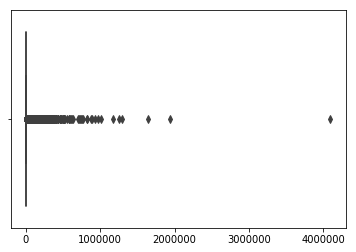

In [32]:
sns.boxplot(residuals_result)

In [31]:
residuals = np.absolute(residuals_result)
residuals_df = pd.DataFrame(residuals)
residuals_df.describe()

,0
count,3.638340e+05
mean,3.142650e+03
std,1.371999e+04
min,1.208288e-03
25%,6.248883e+02
50%,1.538610e+03
75%,3.215312e+03
max,4.095259e+06


In [36]:
residuals_df.quantile(0.99)

0    24389.578586
Name: 0.99, dtype: float64

In [7]:
cleaned_data = process_df(shuffled_data,2,True)

363834
360195
360195
